## Gamera Task 4

4a. Given a magnetic field of 1 muG and the CMB, what loss process dominates for electrons as a function of energy? How do the loss times scale with energy?  How does this change if the magnetic field and CMB temperature change?

4b. Now evolve an E^-2 injected electron spectrum in the 1 muG magnetic field and CMB. How does the spectrum change over time? How does this relate to the cooling times from above?

In [1]:
import sys
sys.path.append('/lfs/l7/hawc/users/gschwefer/software/GAMERA/lib')
import gappa as gp

In [2]:
import numpy as np
import matplotlib.pyplot as plt


We set up a simple function making use of Gamera's `GetCoolingTmeScale` functionality. This is of course independent of the electrons considered and just a pure characteristic of the loss process, sow e don't need to set any properties of the electrons. It is a function of the two parameters we want to vary, the magnetic field and the CMB temperature as well as the energies we want to evaluate the loss time at

In [6]:
def calc_loss_times(B_field, T_cmb,energies):
    fp = gp.Particles()

    fp.AddThermalTargetPhotons(T_cmb,0.25*gp.eV_to_erg)
    fp.SetBField(B_field)
    synch_time_scale=np.array(fp.GetCoolingTimeScale(energies,"synchrotron"))[:,1]#in years
    ic_time_scale=np.array(fp.GetCoolingTimeScale(energies,"inverse_compton"))[:,1]#in years
    return synch_time_scale,ic_time_scale

Now we evaluate for our default parameters. We choose a very wide energy range toreach the Klein-Nishiina regie for IC losses at high energies

In [24]:
energies=np.geomspace(1e-3,1e5,100)*gp.TeV_to_erg
synch_time,ic_time=calc_loss_times(1e-6,2.7,energies)

Particles::SetMembers: Time (0yrs vs {3.16881e-08,1e+100}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
>> CALCULATING IC LOSS LOOKUP 
    99% doneone
    -> DONE!   

>> COMPUTATION OF IC LOSS LOOKUP COMPLETE 



(10, 53525704984.67261)

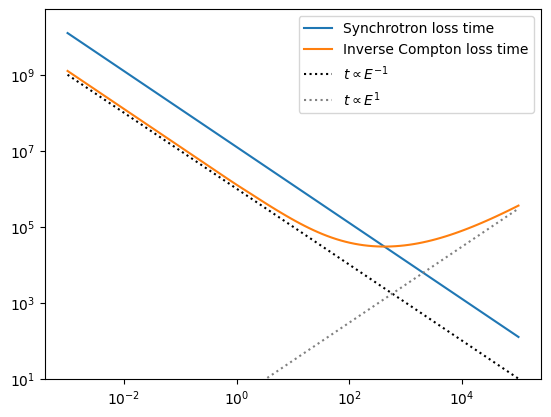

In [29]:
plt.loglog(energies/gp.TeV_to_erg,synch_time,label="Synchrotron loss time")
plt.loglog(energies/gp.TeV_to_erg,ic_time,label="Inverse Compton loss time")
plt.loglog(energies/gp.TeV_to_erg,1e6*(energies/gp.TeV_to_erg)**-1,label="$t\propto E^{-1}$",color="black",linestyle="dotted")
plt.loglog(energies/gp.TeV_to_erg,3*(energies/gp.TeV_to_erg)**1,label="$t\propto E^{1}$",color="grey",linestyle="dotted")
plt.legend()
plt.ylim(bottom=10)
plt.xlabel("$E$ in TeV")
plt.ylabel("Loss time in yrs")

For these parameters, Inverse Compton losses dominate over synchrotron losses for energies below a couple of 100 TeVs. Above that, the Klein-Nishina suppression sets in and synchrotron losses dominate. For synchrotron losses and IC losses in the Thomson regime, energy losses are proportional to E^2, so the loss time goes as E^-1. In the KN limit, the energy loss is almost independent of electron energy, so, so the loss time increases proportional to E. For more details, see Blumenthal and Gould 1970 

Let's vary the B-field and CMB Temp

In [30]:
synch_time_high,ic_time_high=calc_loss_times(1e-5,27,energies)
synch_time_low,ic_time_low=calc_loss_times(1e-7,0.27,energies)

Particles::SetMembers: Time (0yrs vs {3.16881e-08,1e+100}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
>> CALCULATING IC LOSS LOOKUP 
    99% done
    -> DONE!   

>> COMPUTATION OF IC LOSS LOOKUP COMPLETE 

Particles::SetMembers: Time (0yrs vs {3.16881e-08,1e+100}) outside boundaries.
  -> Using values from previous time step. If you don't want this, you have to extend 
     your Lookups (Luminosity,R,V,B,N etc) or set constant values (via e.g. SetBField()). 
>> CALCULATING IC LOSS LOOKUP 
    99% done
    -> DONE!   

>> COMPUTATION OF IC LOSS LOOKUP COMPLETE 



and plot again

Text(0, 0.5, 'Loss time in yrs')

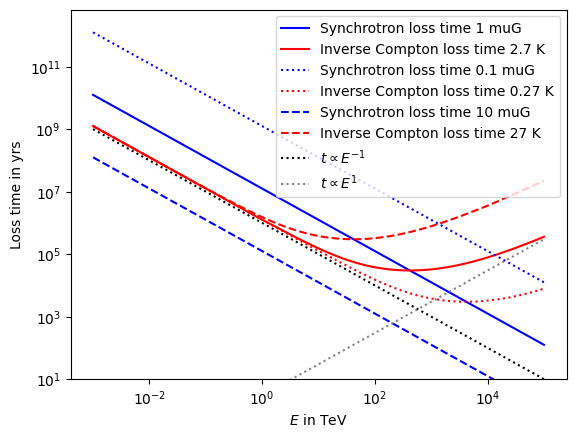

In [33]:
plt.loglog(energies/gp.TeV_to_erg,synch_time,label="Synchrotron loss time 1 muG",color="blue")
plt.loglog(energies/gp.TeV_to_erg,ic_time,label="Inverse Compton loss time 2.7 K",color="red")
plt.loglog(energies/gp.TeV_to_erg,synch_time_low,label="Synchrotron loss time 0.1 muG",color="blue",linestyle="dotted")
plt.loglog(energies/gp.TeV_to_erg,ic_time_low,label="Inverse Compton loss time 0.27 K",color="red",linestyle="dotted")
plt.loglog(energies/gp.TeV_to_erg,synch_time_high,label="Synchrotron loss time 10 muG",color="blue",linestyle="dashed")
plt.loglog(energies/gp.TeV_to_erg,ic_time_high,label="Inverse Compton loss time 27 K",color="red",linestyle="dashed")
plt.loglog(energies/gp.TeV_to_erg,1e6*(energies/gp.TeV_to_erg)**-1,label="$t\propto E^{-1}$",color="black",linestyle="dotted")
plt.loglog(energies/gp.TeV_to_erg,3*(energies/gp.TeV_to_erg)**1,label="$t\propto E^{1}$",color="grey",linestyle="dotted")
plt.legend()
plt.ylim(bottom=10)
plt.xlabel("$E$ in TeV")
plt.ylabel("Loss time in yrs")

For synchrotron losses, the loss time scales proportional to B^-2. For Inverse Compton, for a constant energy density of the radiation field, the only difference with the temperature is the earlier or later onset of the Klein-Nishina suppression

### Task 4b

We're going to once again encapsulate the functionality in a function. As parameters, it takes the source age, B field and CMB temperature as well as the electron energies we want to evaluate this at. 

There is one subtlety here: The electron energies at which the evolved spectrum is given do not correspond to the energies at which the injected spectrum is defined. So we need to take the energies that are part of the output of the evolved particle spectrum as done below

In [48]:
def get_evolved_particle_spectrum(t_age, B_field, T_cmb,el_energies):
    #el_energies in TeV
    e = el_energies * gp.TeV_to_erg # energy axis
    power_law = e**-2 # define power law
    particles = list(zip(e,power_law))
    fp = gp.Particles()
    fp.SetCustomInjectionSpectrum(particles)
    fp.AddThermalTargetPhotons(T_cmb,0.25*gp.eV_to_erg)
    fp.SetBField(B_field)
    fp.SetAge(t_age)
    fp.CalculateElectronSpectrum()
    el_spec=np.array(fp.GetParticleSpectrum())[:,1]
    energies=np.array(fp.GetParticleSpectrum())[:,0]
    return energies,el_spec


Let's evalaute this for a few source ages

In [67]:
energies = np.geomspace(1e-2,1e3,200)
energies_plot_1e4,spec_1e4=get_evolved_particle_spectrum(1e4,1e-6,2.7,energies)
energies_plot_1e5,spec_1e5=get_evolved_particle_spectrum(1e5,1e-6,2.7,energies)
energies_plot_1e6,spec_1e6=get_evolved_particle_spectrum(1e6,1e-6,2.7,energies)
energies_plot_1e7,spec_1e7=get_evolved_particle_spectrum(1e7,1e-6,2.7,energies)
energies_plot_1e8,spec_1e8=get_evolved_particle_spectrum(1e8,1e-6,2.7,energies)

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
>> CALCULATING IC LOSS LOOKUP 
    99% doneone
    -> DONE!   

>> COMPUTATION OF IC LOSS LOOKUP COMPLETE 

** Evolving Electron Spectrum:
    99% done                                                           
    -> DONE!   

>> PARTICLE EVOLUTION DONE. EXITING.

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
>> CALCULATING IC LOSS LOOKUP 
    99% done
    -> DONE!   

>> COMPUTATION OF IC LOSS LOOKUP COMPLETE 

** Evolving Electron Spectrum:
    99% done                                                           
    -> DONE!   

>> PARTICLE EVOLUTION DONE. EXITING.

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
>> CALCULATING IC LOSS LOOKUP 
    99% done
    -> DONE!   

>> COMPUTATION OF IC LOSS LOOKUP COMPLETE 

** Evolving Electron Spectrum:
    99% done                                      

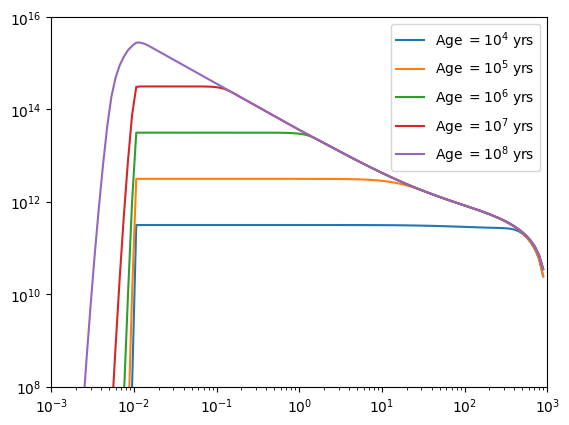

In [71]:
plt.loglog(energies_plot_1e4/gp.TeV_to_erg,(energies_plot_1e4)**2*spec_1e4,label="Age $= 10^4$ yrs")
plt.loglog(energies_plot_1e5/gp.TeV_to_erg,(energies_plot_1e5)**2*spec_1e5,label="Age $= 10^5$ yrs")
plt.loglog(energies_plot_1e6/gp.TeV_to_erg,(energies_plot_1e6)**2*spec_1e6,label="Age $= 10^6$ yrs")
plt.loglog(energies_plot_1e7/gp.TeV_to_erg,(energies_plot_1e7)**2*spec_1e7,label="Age $= 10^7$ yrs")
plt.loglog(energies_plot_1e8/gp.TeV_to_erg,(energies_plot_1e8)**2*spec_1e8,label="Age $= 10^8$ yrs")
plt.ylim(bottom=1e8,top=1e16)
plt.xlim(left=1e-3,right=1e3)
plt.legend()

Because the high-energy particles cool fastest, the spectrum softens over time. The position of the spectral break at any given time corresponds to the energy for which the cooling time equals the source age. 